In [1]:
import os
import sys
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np
import numpy.testing as npt
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import VisionDataset
from torch.utils.data import Subset, DataLoader
from torchvision.datasets.utils import check_integrity, download_and_extract_archive, download_url, verify_str_arg
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import shutil
from PIL import Image,ImageFile
import glob
import os
import sys
import torch
from torch import Tensor
import torch.testing as torch_testing
from torch.utils.data import Subset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
import torchvision.transforms as transforms
import numpy as np
import numpy.testing as npt
from functools import reduce
import matplotlib.pyplot as plt
import os
import pickle
import cv2
from dataclasses import dataclass
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate
import pprofile
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import torchmetrics
import wandb

In [2]:
# torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

`segmentation mini-project` CNN architecture, training loop, perform hyperparameter search and evaluate the best segmentation module. Inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.

In [3]:
def upsample_block(x, number_of_filters, filter_size, stride = 2):
    output_channels = x.shape[1] // 2
    x = torch.nn.ConvTranspose2d(in_channels=x.shape[1], out_channels=output_channels, kernel_size=filter_size, stride=stride)(x)
    x = torch.nn.BatchNorm2d(x.shape[1])(x)
    x = torch.nn.ReLU()(x)
    return x

in_layer = torch.rand((32, 32, 128, 128))

filter_size = 4
number_of_filters = 16

expected_shapes = [
    (32, 16, 258, 258),
    (32, 16, 512, 512),
    (32, 16, 1020, 1020)
]
strides = [2, 4, 8]

for expected_shape, stride in zip(expected_shapes, strides):
    x = upsample_block(in_layer, number_of_filters, filter_size, stride)
    print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_size, '; stride ', stride, ' -> out shape ', x.shape)
    npt.assert_array_equal(x.shape, expected_shape)

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 258, 258])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 512, 512])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1020, 1020])


`down-sampling` class Encoder. Each block: 2 convolution layers with 3 filter_size and a non liniar ReLu. Blocks separated by max pooling with size of 2 and stride of 2.

Parameters:
`channel_numbers`: list of integers, the number of channels used for each encoder block.

`retrun`: list of tensors, the output of each encoder block.

Diagram used in tests:
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png" style="width:40vw; margin-left:20vw"/>

In [4]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.conv(x)

in_layer = torch.rand((1, 1, 512, 512)) # 1 number of images, 1 channel, 572x572 pixels
expected_shape = (1, 64, 512, 512)
model = DoubleConvolution(1, 64)
in_layer = model(in_layer)
print('in shape: ', in_layer.shape, ' out shape ', in_layer.shape)
npt.assert_array_equal(in_layer.shape, expected_shape)

in shape:  torch.Size([1, 64, 512, 512])  out shape  torch.Size([1, 64, 512, 512])


In [5]:
class DownSamplingNeuralNetwork(nn.Module): # Encoder
    def __init__(self, in_channels=1, features=[64,128,256,512]):
        super(DownSamplingNeuralNetwork, self).__init__()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for feature in features:
            self.downs.append(DoubleConvolution(in_channels, feature))
            in_channels = feature

    def forward(self, x):
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pool(x)
        return skips, x

# Test the down sampling network
in_layer = torch.rand((1, 1, 512, 512)) # 1 number of images, 1 channel, 572x572 pixels
expected_shape = (1, 512, 64, 64)
model = DownSamplingNeuralNetwork(in_channels=1,features=[64,128,256,512])
skips, _ = model(in_layer)
print('in shape: ', in_layer.shape, ' out shape ', skips[-1].shape)
npt.assert_equal(skips[-1].shape, expected_shape)

in shape:  torch.Size([1, 1, 512, 512])  out shape  torch.Size([1, 512, 64, 64])


`up-sapling` class Decoder.

Constructor parameters:`depth`: the depth of each decoder module

Forward parameters:

`x`: the input feature map
`encoder_activations`: a list of activations from the encoder (for the skip connections)

`Forward function`:

1. up-sampling operation normalization and ReLU
2. crop the activation map (use `CenterCrop`): to be the same size as the decoder block
3. concatenate these two activation maps (on the channel dimension, 1)
4. apply an encoder block on the result
5. pass the result to the next decoder block

In [6]:
class UpSamplingNeuralNetwork(nn.Module):
    def __init__(self, out_channels=1, features=[64,128,256,512]):
        super(UpSamplingNeuralNetwork, self).__init__()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConvolution(feature*2, feature))
        
        self.bottleneck = DoubleConvolution(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x: Tensor, skip_connections) -> Tensor:
        # x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                # Use CenterCrop
                # x = TF.center_crop(x, output_size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.softmax(self.final_conv(x))

in_layer = torch.rand((1, 512, 64, 64))
expected_shape = (1, 1, 512, 512)
model = UpSamplingNeuralNetwork()
output = model(in_layer, skips)
print('in shape: ', in_layer.shape, ' out shape ', output.shape)
npt.assert_equal(output.shape, expected_shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


in shape:  torch.Size([1, 512, 64, 64])  out shape  torch.Size([1, 1, 512, 512])


In [7]:
class UNET_BY_UP_AND_DOWN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128,256,512]):
        super(UNET_BY_UP_AND_DOWN, self).__init__()
        self.downs = DownSamplingNeuralNetwork(in_channels, features)
        self.ups = UpSamplingNeuralNetwork(out_channels, features)
    
    def forward(self, x):
        skips, x = self.downs(x)
        return self.ups(x, skips)

in_layer = torch.rand((1, 1, 512, 512))
model = UNET_BY_UP_AND_DOWN(in_channels=1, out_channels=1)
output = model(in_layer)
print(output.shape)
print(in_layer.shape)
assert output.shape == in_layer.shape

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


`UNET` single class - simpler approach

In [8]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128,256,512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConvolution(in_channels, feature))
            in_channels = feature
        
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConvolution(feature*2, feature))
        
        self.bottleneck = DoubleConvolution(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x: Tensor) -> Tensor:
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                # Use CenterCrop
                # x = TF.center_crop(x, output_size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)

in_layer = torch.rand((1, 3, 128, 128))
model = UNET(in_channels=3, out_channels=3)
output = model(in_layer)
print(output.shape)
print(in_layer.shape)
assert output.shape == in_layer.shape

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


`pre-trained` model: pre-trained weights on `ImageNet` and "freeze these weights during the training process (set `required_grad=False` for those tensors).

`Problem`: We neet to create the skip connections required by the U-Net architecture we need access to the feature maps of some intermediate layers in the network and these are not accessible by default.

Finally, to have matching shapes between the network output (segmentation map) and the ground truth data, resize the segmentation map using ``torch.nn.functional.interpolate``: Not necessary, as we have the same size of the input and output.

`Training`

- Get a batch of training data from the DataLoader
- Zero out the optimizer’s gradients
- Perform the forward pass
- Calculate and store the loss and the accuracy based on the predictions and the labels from the dataset
- Tell the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
- Evaluate the model on the validation/test set. Store the loss and the accuracy on the validation/test set.

`Dataset`: We need a train and a test DataLoader and you must first define the loss function cross entropy and select an optimizer.

In [9]:
# Class arhchitecture inspired by https://pytorch.org/vision/main/_modules/torchvision/datasets/oxford_iiit_pet.html

class _LFW(torch.utils.data.Dataset):
    files = {
        "people_funneled": ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", "images.tgz", "1b42dfed7d15c9b2dd63d5e5840c86ad"),
        "segmentation_mask": ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz", "segmentations.tgz", "3e7e26e801c3081d651c8c2ef3c45cfc"),
        "train": ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_train.txt", "train.txt", None),
        "test": ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_test.txt", "test.txt", None),
    }
    
    def __init__(self, base_folder: str, transform, target_transforms, download: bool=True):
        super().__init__()
        self._base_folder = base_folder
        self.transform = transform
        self.target_transforms = target_transforms
        self.data: List[Any] = []
        self.split = None
        self.images_dir = os.path.join(self._base_folder, "lfw_funneled")
        self.segmentations_dir = os.path.join(self._base_folder, "parts_lfw_funneled_gt_images")
        
        if download:
            self._download()
        if not self._check_integrity(): # Optional, just checking if everything is ok with the data
            raise RuntimeError("Data not found or corrupted.")
    
    def _load_image(self, path: str):
        with Image.open(path) as image:
            return image.convert("RGB")

    def _load_segmentation(self, path: str):
        with Image.open(rf"{path}") as image:
            return image.convert("RGB")
    
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = self._load_image(self.data[index][0])
        segmentation = self._load_segmentation(self.data[index][1])
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transforms is not None:
            segmentation = self.target_transforms(segmentation)
        return image, segmentation
    
    def _check_integrity(self) -> bool:
        ok = True
        for file in self.files.values():
            if file[2] == None:
                ok&= os.path.exists(os.path.join(self._base_folder, file[1]))
                continue
            ok &= check_integrity(os.path.join(self._base_folder, file[1]), file[2])
        if not ok:
            return False
        return True
    
    def _download(self):
        if self._check_integrity():
            print("Dataset already downloaded and verified")
            return

        for url, filename, md5 in self.files.values():
            if md5 == None:
                download_url(url, root=self._base_folder, filename=filename, md5=md5)
                continue
            if not check_integrity(os.path.join(self._base_folder, filename), md5):
                download_and_extract_archive(url, download_root=self._base_folder, filename=filename, md5=md5)

class LFWDataset(_LFW):
    def __init__(self, base_folder: str, transform, target_transforms, download: bool=True, split="train"):
        super().__init__(base_folder, transform, target_transforms, download)
        self._image_plus_segmentation_path = os.path.join(self._base_folder, f"{split}.txt")
        self._load_data()
        self.transforms = transform
    
    def _load_data(self):
        self.data = [] # These are just the paths to the images and segmentations
        with open(self._image_plus_segmentation_path, "r") as f:
            for line in f.readlines():
                name, index = line.strip().split(" ")
                if len(index) != 4:
                    index = "0"*(4-len(index)) + index
                name_image = os.path.join(self.images_dir, name, f"{name}_{index}.jpg")
                segmentation_image = os.path.join(self.segmentations_dir, f"{name}_{index}.ppm")
                if os.path.exists(name_image) and os.path.exists(segmentation_image):
                    self.data.append((name_image, segmentation_image))

In [10]:
transforms = v2.Compose([v2.Resize(128), v2.ToTensor()])
target_transforms = v2.Compose([v2.Resize(128), v2.ToTensor(), v2.Lambda(lambda x: x.argmax(dim=0))]) # , v2.Lambda(lambda x: x.bool())
train_dataset = LFWDataset(base_folder='./data', split="train", download=True, transform=transforms, target_transforms=target_transforms)
validation_dataset = LFWDataset(base_folder='./data', split="test", download=True, transform=transforms, target_transforms=target_transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Dataset already downloaded and verified
Dataset already downloaded and verified


`RamDataset`

In [11]:
# code /root/.jupyter/jupyter_notebook_config.py
# c.NotebookApp.max_buffer_size = 20000000000
# 9GB RAM, Issue on github PPM takes lot of ram
# Performance improvement, should be used only with small datasets, delete cell if you don't have enough RAM, should work OOTB
class RamDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: LFWDataset):
        data_loader = DataLoader(dataset, batch_size=len(dataset))
        self._images, self._segmentations = next(iter(data_loader))
    def __getitem__(self, index):
        return self._images[index], self._segmentations[index]
    def __len__(self):
        return self._images.shape[0]

train_dataset = RamDataset(train_dataset)
validation_dataset = RamDataset(validation_dataset)

Number of samples in the train_dataset:  1500
Shape of the first image: torch.Size([3, 128, 128]), dtype=torch.float32
Shape of the segmentation of first image: torch.Size([128, 128]), dtype=torch.int64


Text(0.5, 1.0, 'Segmentation')

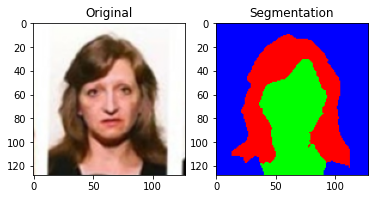

In [12]:
# Simple validation to see that everything is alwright
print("Number of samples in the train_dataset: ", len(train_dataset))
print(f"Shape of the first image: {train_dataset[0][0].shape}, dtype={train_dataset[0][0].dtype}")
print(f"Shape of the segmentation of first image: {train_dataset[0][1].shape}, dtype={train_dataset[0][1].dtype}")
first_image = train_dataset[0][0].cpu().numpy().transpose(1, 2, 0)
first_image_segmentation = F.one_hot(train_dataset[0][1]).float().cpu().numpy()
plt.subplot(1, 2, 1).imshow(first_image)
plt.title(f"Original")
plt.subplot(1, 2, 2).imshow(first_image_segmentation)
plt.title(f"Segmentation")

`Dataloader`

In [13]:
learning_rate = 1e-4
weight_decay = 1e-4
batch_size = 15
number_of_epochs = 20

In [14]:
training_loader, validation_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True), DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

`Actual training`: We will use the simpler implementation of the U-Net.

In [15]:
def train_one_epoch(loader, model, optimizer, loss_function, scheduler): # 1 epoch
    for data, targets in tqdm.tqdm(loader):
        data, targets = data.to(device), targets.to(device)
        predictions = model(data)
        loss = loss_function(predictions, targets)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        wandb.log({"loss": loss.item()})
        # update tqdm loop
    scheduler.step()

`Saving & Loading` to resume training

In [16]:
@dataclass
class InputParameters:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    scheduler: torch.optim.lr_scheduler._LRScheduler

def save_checkpoint(model, optimizer, scheduler, filename):
    print("=> Saving checkpoint")
    input_parameters = InputParameters(model, optimizer, scheduler)
    torch.save(input_parameters, filename)

def load_checkpoint(filename):
    print("=> Loading checkpoint")
    input_parameters = torch.load(filename)
    return input_parameters.model, input_parameters.optimizer, input_parameters.scheduler

class ModelCheckpoint:
    def __init__(self):
        self.best_model = None
        self.best_metric = 0
        self.best_epoch = 0

    def __call__(self, model, optimizer,scheduler, epoch, metric_value):
        if metric_value > self.best_metric:
            self.best_metric = metric_value
            self.best_model = model
            self.best_epoch = epoch
            #Save:
            save_checkpoint(model, optimizer, scheduler, f"./checkpoints/iou_{metric_value}.pth")
            print(f"Saved checkpoint with iou={metric_value}")
        else:
            print(f"Did not save checkpoint with iou={metric_value}")
    
    def write_artifact(self, path, model_path, metric_val):
        artifact = wandb.Artifact(path, type='model', metadata={'metric': metric_val})
        artifact.add_file(model_path)
        wandb.run.log_artifact(artifact)

- $n_{ij}$ - the total number of pixels classified to class
j but actually belonging to class i; $i, j \in 1, .., C$;
- $t_i = \sum_{j = 1}^{C} n_{ij}$ - the total number of pixels belonging to class $i$ (in the ground truth segmentation mask);
- $C$ - the total number of classes in the segmentation problem.

`Mean pixel accuracy`: is not that relevant for class imbalanced problems
\begin{equation}
p_a = \frac{1}{C} \frac{\sum_{i}^{C} n_{ii}}{\sum_{i}^{C} t_i}
\end{equation}

`Intersection over Union (IoU)`: The ideal value for this metric is 1; usually values lower than 0.6 indicate a very bad performance.

\begin{equation}
mIoU = \frac{1}{C} \sum_{i = 1}^{C} \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

`Frequency Weighted Intersection over Union`: The frequency weighted over union metric is similar to mean IoU, but the values are weighted with the adequate frequencies of the pixels. The values of this metric lie in the interval [0, 1], and the ideal value for this metric is 1.

\begin{equation}
fIou = (\sum_{i = 1}^{k} t_i)^{-1}   \sum_{i = 1}^{C} t_i \cdot \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

In [17]:
def get_accuracy(real_target, predicted_target):
    real_target, predicted_target = real_target.argmax(dim=1), predicted_target.argmax(dim=1)
    return ((real_target == predicted_target).sum() / real_target.numel()).item()

def intersection_over_union(real_target, predicted_target):
    real_target = real_target.bool()
    predicted_target = predicted_target.bool()
    intersection = (real_target & predicted_target).sum()
    union = (real_target | predicted_target).sum()
    return intersection / union

def intersection_over_union_weighted(real_target, predicted_target):
    real_target = real_target.bool()
    predicted_target = predicted_target.bool()
    intersection = (real_target & predicted_target).sum(dim=(0, 2, 3))
    union = (real_target | predicted_target).sum(dim=(0, 2, 3))
    return (intersection / union).sum() / intersection.sum()

def check_metrics(loader, model):
    model.eval()

    with torch.no_grad():
        all_predicted_targets = torch.tensor([]).to(device)
        all_real_targets = torch.tensor([]).to(device)
        ok=True
        for x,y in loader:
            x,real_target = x.to(device), F.one_hot(y.to(device))
            predicted_target= F.one_hot(model(x).to(device).argmax(dim=1), num_classes=3)
            all_predicted_targets = torch.cat((all_predicted_targets, predicted_target))
            all_real_targets = torch.cat((all_real_targets, real_target))
            if ok is True:
                ok=False
                predicted_mask = predicted_target[0].float().cpu().numpy()
                real_mask = real_target[0].float().cpu().numpy()
                image = x[0].cpu().numpy().transpose(1, 2, 0)
                plt.imsave("predicted.jpg", predicted_mask)
                plt.imsave("real.jpg", real_mask)
                plt.imsave("image.jpg", image)
                columns = ["Real image", "Ground truth", "Predicted segmentation"]
                table = wandb.Table(columns=columns, data=[[wandb.Image("image.jpg"), wandb.Image("real.jpg"), wandb.Image("predicted.jpg")]])
                wandb.log({"Predictions": table})
        accuracy = get_accuracy(all_real_targets, all_predicted_targets)
        jacard_index = intersection_over_union(all_real_targets, all_predicted_targets)
        frequency_weighted_iou = intersection_over_union_weighted(all_real_targets, all_predicted_targets)
    model.train()
    return accuracy, (jacard_index*100).int(), frequency_weighted_iou

In [18]:
sweep_config: dict = {
    "project": "school-project",
    "metric":
        {"name": "loss","goal": "minimize"}
    ,
    "method": "grid", # grid/random
    "parameters": None,
}
parameters: dict = {
    "learning_rate": {
        "values": [1e-4, 1e-5, 1e-6]
    },
    "number_of_epochs": {
        "values": [8,9,10]
    },
    "features":
    {
        "values":
        [
            [64,128,256],
            [64,128,256,512]
        ]
    }
}
sweep_config["parameters"] = parameters
sweep_id = wandb.sweep(sweep_config) # https://wandb.ai/catalin-ai/school-project/sweeps/e0tzl5sq
# https://wandb.ai/catalin-ai/school-project/sweeps/2rxfxvn8
# GRID SEARCH: https://wandb.ai/catalin-ai/school-project/runs/nsaah8vf

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: svitqdht
Sweep URL: https://wandb.ai/catalin-ai/school-project/sweeps/svitqdht


In [19]:
device = torch.device("cpu")
loss_function = nn.CrossEntropyLoss()
# iou = 88
# model,optimizer, scheduler = load_checkpoint(f"./checkpoints/iou_{iou}.pth")

def agent_function():
    run = wandb.init(config=sweep_config)
    learning_rate = wandb.config.learning_rate
    number_of_epochs = wandb.config.number_of_epochs
    features = wandb.config.features
    wandb.log({"learning_rate": learning_rate, "number_of_epochs": number_of_epochs, "features": len(features)})
    model = UNET(in_channels=3, out_channels=3, features=features).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    for epoch in range(number_of_epochs):
        train_one_epoch(training_loader, model, optimizer, loss_function, scheduler)
        accuracy, iou, _ = check_metrics(validation_loader, model)
        wandb.log({"accuracy": accuracy, "iou": iou})
        save_checkpoint(model, optimizer, scheduler, f"./checkpoints/iou_{iou}_{len(features)}_features.pth")
    run.finish()

# wandb.agent(sweep_id, function=agent_function, count=2)

In [20]:
class ModelCheckpoint:
    def __init__(self):
        self.best_metric = None
        self.artifact = wandb.Artifact(name="model_parameters", type="model")
    
    def save(self, file_path, metric):
        if self.best_metric is None or metric > self.best_metric:
            self.best_metric = metric
            self.artifact.add_file(file_path)

In [23]:
model_checkpoint = ModelCheckpoint()
device = torch.device("cpu")
iou = 89
features = [64]
n_features = 1
run = wandb.init(config=sweep_config)

# model, optimizer, scheduler =  load_checkpoint(f"./checkpoints/iou_{iou}_{len(features)}_features.pth")
model = UNET(in_channels=3, out_channels=3, features=features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
for epoch in range(0):
    save_checkpoint(model, optimizer, scheduler, f"./checkpoints/iou_{iou}_{n_features}_features.pth")
    model_checkpoint.save(f"./checkpoints/iou_{iou}_{n_features}_features.pth", iou)
    train_one_epoch(training_loader, model, optimizer, loss_function, scheduler)
    accuracy, iou, _ = check_metrics(validation_loader, model)
    wandb.log({"accuracy": accuracy, "iou": iou})
run.finish()

loss,█▁
loss,1.39734


=> Loading checkpoint


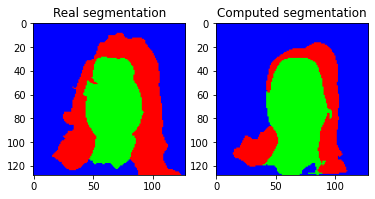

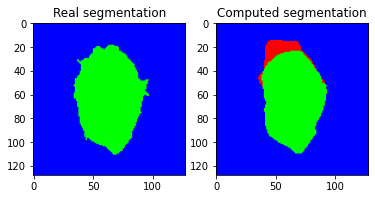

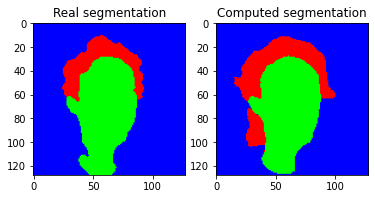

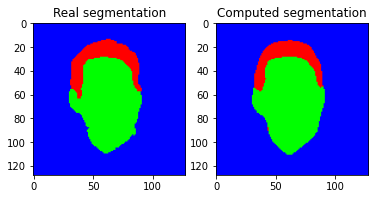

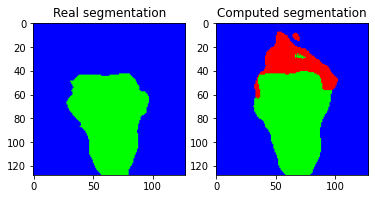

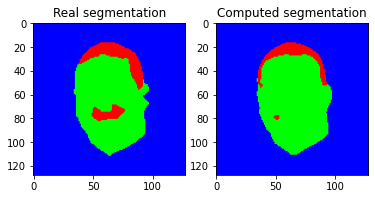

In [26]:
device = torch.device("cuda")
# Generate predictions
model_iou = 89
model,_,_ = load_checkpoint(f"./checkpoints/iou_{model_iou}.pth")
with torch.no_grad():
    i=0
    for x,y in validation_loader:
        x,y = x.to(device), y.to(device)
        preds= model(x).argmax(dim=1)
        real_segmentation = F.one_hot(y[0]).float().cpu().numpy()
        computed_segmentation = F.one_hot(preds[0]).float().cpu().numpy()
        plt.figure(i)
        plt.subplot(1, 2, 1).imshow(real_segmentation)
        plt.title("Real segmentation")
        plt.subplot(1, 2, 2).imshow(computed_segmentation)
        plt.title("Computed segmentation")
        i+=1
        if i==6: # Number of pairs displayed
            break